In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from math import pi # for radar chart

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('allcars.csv', index_col=0).reset_index(drop=True)

In [7]:
df = df.drop(['accData'], axis=1)

In [8]:
df.head()

,timeStamp,tripID,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos,deviceID
0,2017-10-31 18:45:59.000000,0,2.2,14.48,NaN,NaN,44.313725,NaN,NaN,0.0,0.0,903.0,4.0,NaN,15.686275,1
1,2017-10-31 18:46:00.000000,0,3.7,14.48,NaN,NaN,35.294118,NaN,NaN,0.0,0.0,938.0,6.0,NaN,15.294118,1
2,2017-10-31 18:46:01.000000,0,3.9,14.54,NaN,NaN,29.411765,NaN,NaN,0.0,0.0,1044.5,7.0,NaN,14.901961,1
3,2017-10-31 18:46:02.000000,0,3.9,14.56,NaN,NaN,53.725490,NaN,NaN,0.0,0.0,1102.0,7.0,NaN,17.647059,1
4,2017-10-31 18:46:03.000000,0,4.7,14.48,NaN,NaN,75.686275,NaN,NaN,0.0,0.0,1626.5,10.0,NaN,23.529412,1


In [9]:
df['deviceID'].nunique()

29

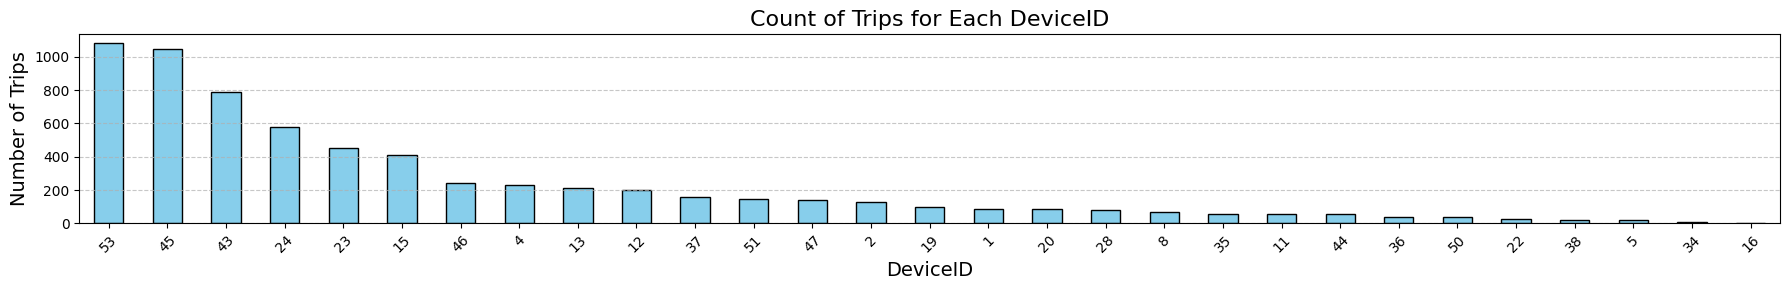

In [10]:
import matplotlib.pyplot as plt

# Count the number of trips for each deviceID
trip_counts = df.groupby('deviceID')['tripID'].nunique()

# Plot the bar chart
plt.figure(figsize=(18, 3))
trip_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Count of Trips for Each DeviceID', fontsize=16)
plt.xlabel('DeviceID', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# Count the number of trips for each deviceID
trip_counts = df.groupby('deviceID')['tripID'].nunique()

# Sort the counts in ascending order and get the 5 lowest values
lowest_trip_counts = trip_counts.sort_values(ascending=True).head(5)

# Print the results
print("Top 5 DeviceIDs with the Lowest Number of Trips:")
print(lowest_trip_counts)

Top 5 DeviceIDs with the Lowest Number of Trips:
deviceID
16     1
34    10
38    22
5     22
22    27
Name: tripID, dtype: int64


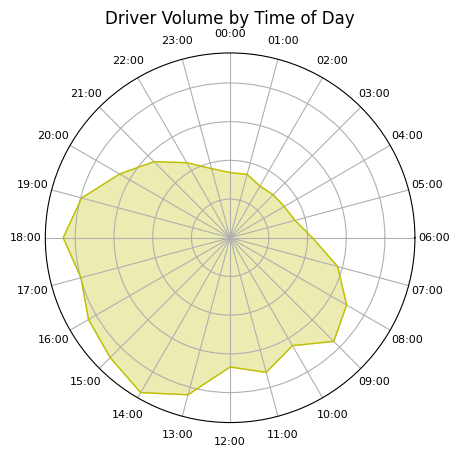

In [12]:
# radar chart to visualize distribution of datapoints by the hour
hour_buckets = pd.to_datetime(df['timeStamp']).dt.hour.value_counts().sort_index()
hours, hour_counts = hour_buckets.index.to_list(), hour_buckets.to_list()

# rotate by 90 degrees counter clockwise so the chart is more
# intuitive, then reverse
hours = (hours[7:] + hours[:7])[::-1]
hour_counts = (hour_counts[7:] + hour_counts[:7])[::-1]

# turn hours into a reader-friendly format
hours = [str(h).zfill(2) + ':00' for h in hours]

hour_counts.append(hour_counts[0])
N = len(hours)
angles = [i / float(N) * 2 * pi for i in range(N)]
angles.append(angles[0])

ax = plt.subplot(polar=True)
plt.title('Driver Volume by Time of Day\n')
plt.xticks(angles[:-1], hours, size=8)
ax.set_yticklabels([])
ax.plot(angles, hour_counts, color='y', linewidth=1)
ax.fill(angles, hour_counts, alpha=0.3, color='y')
plt.show()

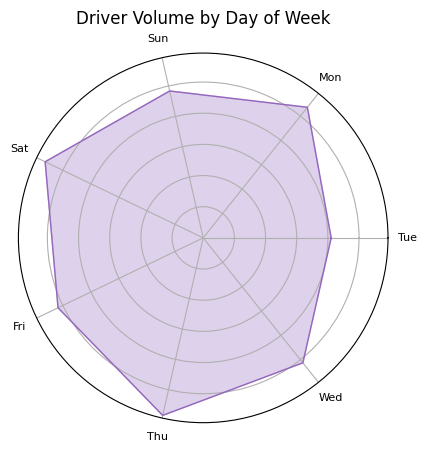

In [13]:
# radar chart to visualize distribution of datapoints by the day of week
wd_buckets = pd.to_datetime(df['timeStamp']).dt.weekday.value_counts().sort_index()
weekdays, wd_counts = wd_buckets.index.to_list(), wd_buckets.to_list()
wd_list = [
    'Mon',
    'Tue',
    'Wed',
    'Thu',
    'Fri',
    'Sat',
    'Sun'
]
weekdays = [wd_list[x] for x in weekdays]

# rotate counter clockwise so the chart is more
# intuitive, then reverse
weekdays = (weekdays[2:] + weekdays[:2])[::-1]
wd_counts = (wd_counts[2:] + wd_counts[:2])[::-1]

wd_counts.append(wd_counts[0])
N = len(weekdays)
angles = [i / float(N) * 2 * pi for i in range(N)]
angles.append(angles[0])

ax = plt.subplot(polar=True)
plt.title('Driver Volume by Day of Week\n')
plt.xticks(angles[:-1], weekdays, size=8)
ax.set_yticklabels([])
ax.plot(angles, wd_counts, color='tab:purple', linewidth=1)
ax.fill(angles, wd_counts, alpha=0.3, color='tab:purple')
plt.show()

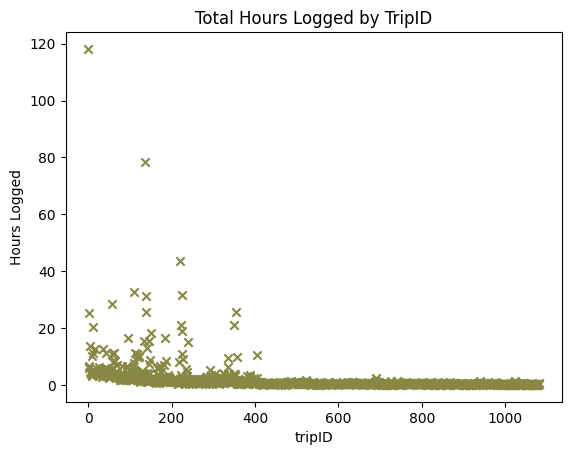

In [14]:
hours_by_trip = df['tripID'].value_counts()/(60*60)
plt.scatter(x=hours_by_trip.index, y=hours_by_trip,
           color='#888844', marker='x')
plt.title('Total Hours Logged by TripID')
plt.xlabel('tripID')
plt.ylabel('Hours Logged')
plt.show()

In [15]:
hours_by_trip.sort_values(ascending=False).head(5)

tripID
0      118.153056
136     78.261111
220     43.567500
109     32.806667
224     31.734444
Name: count, dtype: float64

In [16]:
total_trip_ids = hours_by_trip.index.tolist()
print("Total Trip IDs:", len(total_trip_ids))

Total Trip IDs: 1082


In [17]:
valid_trips = hours_by_trip[(hours_by_trip >= 0.1) & (hours_by_trip <= 40)]

valid_trip_ids = valid_trips.index.tolist()
print("Valid Trip IDs:", len(valid_trip_ids))

Valid Trip IDs: 1050


In [18]:
df = df[df['tripID'].isin(valid_trip_ids)]

In [19]:
def handle_missing_values_device_level(df):
    # List of numerical columns to impute
    numerical_columns = ['battery', 'cTemp', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos']
    
    # Group by 'deviceID' and fill missing values with the mean for each device
    df_imputed = df.copy()
    for col in numerical_columns:
        # For each column, group by 'deviceID' and fill NaN values with the mean of the group
        df_imputed[col] = df.groupby('deviceID')[col].transform(lambda x: x.fillna(x.mean() if not x.isnull().all() else 0))
    
    return df_imputed

# Apply the function
df = handle_missing_values_device_level(df)

In [20]:
# filtering out suspiciously high speed measurements
df = df[df['speed'] < 157]
# tPos has a very thick right tail which is extremely unlikely
df = df[df['tPos'] < 80]

In [38]:
df.columns

Index(['timeStamp', 'tripID', 'gps_speed', 'battery', 'cTemp', 'dtc', 'eLoad',
       'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos', 'deviceID',
       'acceleration', 'hard_brake', 'high_speed', 'high_throttle',
       'aggressive_acceleration', 'inefficient_driving', 'excessive_idling',
       'fuel_efficiency'],
      dtype='object')

In [21]:
import pandas as pd

# Ensure 'battery' and 'gps_speed' columns are filled with mean values for NaNs
df['battery'] = df['battery'].fillna(df['battery'].mean())
df['gps_speed'] = df['gps_speed'].fillna(df['gps_speed'].mean())

# Replace infinite values with 0 for 'battery' and 'gps_speed'
df['battery'] = df['battery'].replace([float('inf'), -float('inf')], 0)
df['gps_speed'] = df['gps_speed'].replace([float('inf'), -float('inf')], 0)

# Calculate acceleration
df.loc[:, 'timeStamp'] = pd.to_datetime(df['timeStamp'])
df.sort_values(by='timeStamp', inplace=True)
df['timeDelta'] = df['timeStamp'].diff().dt.total_seconds()
df = df[(df['timeDelta'] == 1.0)]
df['diff'] = df['speed'].diff()
df['acceleration'] = df['diff'] / df['timeDelta']
df = df.drop(['diff', 'timeDelta'], axis=1)

# Fill NaN values in 'acceleration' with 0
df['acceleration'].fillna(0, inplace=True)

# Feature engineering
df['hard_brake'] = (df['acceleration'] < -3).astype(int)
df['high_speed'] = (df['gps_speed'] > 80).astype(int)
df['high_throttle'] = (df['tPos'] > 60).astype(int)
df['aggressive_acceleration'] = (df['acceleration'] > 3).astype(int)
df['inefficient_driving'] = ((df['rpm'] > 4000) & (df['gps_speed'] < 30)).astype(int)
df['excessive_idling'] = ((df['gps_speed'] < 5) & (df['tPos'] < 10)).astype(int)

# Calculate 'fuel_efficiency' after ensuring no NaNs or infinite values in 'battery' and 'gps_speed'
df['fuel_efficiency'] = df['battery'] / df['gps_speed']

# Replace infinite values in 'fuel_efficiency' with 0
df['fuel_efficiency'] = df['fuel_efficiency'].replace([float('inf'), -float('inf')], 0)

# Check if NaNs still exist in 'fuel_efficiency'
df['fuel_efficiency'].fillna(0, inplace=True)

# Fill NaN values with the column's mean for continuous features
df['rpm'] = df['rpm'].fillna(df['rpm'].mean())
df['tPos'] = df['tPos'].fillna(df['tPos'].mean())

In [22]:
# Verify if there are any NaNs remaining
print(df.isnull().sum())

timeStamp                        0
tripID                           0
gps_speed                        0
battery                          0
cTemp                            0
dtc                        3044232
eLoad                            0
iat                              0
imap                             0
kpl                              0
maf                              0
rpm                              0
speed                            0
tAdv                             0
tPos                             0
deviceID                         0
acceleration                     0
hard_brake                       0
high_speed                       0
high_throttle                    0
aggressive_acceleration          0
inefficient_driving              0
excessive_idling                 0
fuel_efficiency                  0
dtype: int64


In [23]:
# Step 3: Aggregation by tripID with percentage calculations
df_trip_agg = df.groupby(['tripID', 'deviceID']).agg({
    'acceleration': ['mean', 'std'],
    'gps_speed': ['max', 'mean', 'std'],
    'battery': 'mean',
    'rpm': ['mean', 'max'],
    'speed': 'mean',
    'tPos': 'mean',
    'hard_brake': 'mean',  # Calculate percentage of hard brakes
    'high_speed': 'mean',  # Calculate percentage of high-speed records
    'high_throttle': 'mean',  # Calculate percentage of high throttle usage
    'aggressive_acceleration': 'mean',  # Percentage of aggressive acceleration
    'inefficient_driving': 'mean',  # Percentage of inefficient driving
    'excessive_idling': 'mean',  # Percentage of excessive idling
    'fuel_efficiency': 'mean'
}).reset_index()

df_trip_agg = df_trip_agg.fillna(0)

# Flatten multi-level columns
df_trip_agg.columns = ['_'.join(col).strip() for col in df_trip_agg.columns.values]

In [24]:
df_trip_agg = df_trip_agg[df_trip_agg['gps_speed_mean'] > 0]

# Optionally, reset the index after filtering
df_trip_agg.reset_index(drop=True, inplace=True)

In [25]:
# Count the number of trips for each deviceID
trip_counts = df_trip_agg.groupby('deviceID_')['tripID_'].nunique()

# Sort the counts in ascending order and get the 5 lowest values
lowest_trip_counts = trip_counts.sort_values(ascending=True).head(5)

# Print the results
print("Top 5 DeviceIDs with the Lowest Number of Trips:")
print(lowest_trip_counts)

Top 5 DeviceIDs with the Lowest Number of Trips:
deviceID_
51     3
34     8
38    17
46    19
5     20
Name: tripID_, dtype: int64


In [26]:
df_trip_agg.head()

,tripID_,deviceID_,acceleration_mean,acceleration_std,gps_speed_max,gps_speed_mean,gps_speed_std,battery_mean,rpm_mean,rpm_max,speed_mean,tPos_mean,hard_brake_mean,high_speed_mean,high_throttle_mean,aggressive_acceleration_mean,inefficient_driving_mean,excessive_idling_mean,fuel_efficiency_mean
0,1,4,0.000000,0.000000,10.353362,10.353362,0.000000,12.512599,1173.217542,1173.217542,0.000000,6.076303,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.208554
1,1,8,0.000000,0.000000,10.353362,10.353362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,1,12,-0.014583,3.532332,60.800000,17.300417,13.169915,11.248307,1407.880208,2899.000000,30.697917,15.655229,0.039583,0.0,0.0,0.021875,0.0,0.153125,2.069424
3,1,15,0.000000,0.000000,10.353362,10.353362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,1,23,-5.387931,15.682605,35.400000,7.739224,7.636672,0.000000,660.506466,1763.000000,8.659483,0.000000,0.262931,0.0,0.0,0.094828,0.0,0.383621,0.000000


In [27]:
print(df_trip_agg.isnull().sum())

tripID_                         0
deviceID_                       0
acceleration_mean               0
acceleration_std                0
gps_speed_max                   0
gps_speed_mean                  0
gps_speed_std                   0
battery_mean                    0
rpm_mean                        0
rpm_max                         0
speed_mean                      0
tPos_mean                       0
hard_brake_mean                 0
high_speed_mean                 0
high_throttle_mean              0
aggressive_acceleration_mean    0
inefficient_driving_mean        0
excessive_idling_mean           0
fuel_efficiency_mean            0
dtype: int64


In [28]:
df_trip_agg.count()

tripID_                         5026
deviceID_                       5026
acceleration_mean               5026
acceleration_std                5026
gps_speed_max                   5026
gps_speed_mean                  5026
gps_speed_std                   5026
battery_mean                    5026
rpm_mean                        5026
rpm_max                         5026
speed_mean                      5026
tPos_mean                       5026
hard_brake_mean                 5026
high_speed_mean                 5026
high_throttle_mean              5026
aggressive_acceleration_mean    5026
inefficient_driving_mean        5026
excessive_idling_mean           5026
fuel_efficiency_mean            5026
dtype: int64

In [29]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = [
    'acceleration_mean', 'acceleration_std', 'gps_speed_max', 'gps_speed_mean', 'gps_speed_std',
    'battery_mean', 'rpm_mean', 'rpm_max', 'speed_mean', 'tPos_mean', 'hard_brake_mean',
    'high_speed_mean', 'high_throttle_mean', 'aggressive_acceleration_mean', 
    'inefficient_driving_mean', 'excessive_idling_mean', 'fuel_efficiency_mean'
]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_trip_agg[features])

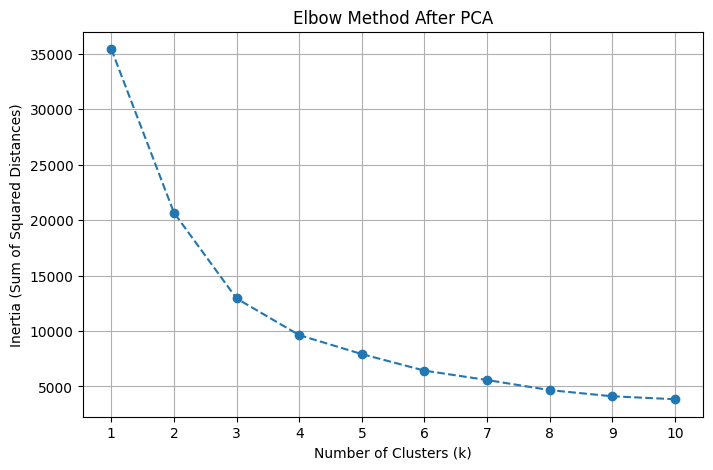

In [30]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_data = pca.fit_transform(df_scaled)

# Step 3: Generate Elbow Graph
def plot_elbow_with_pca(pca_data, max_k=10):
    inertia = []  # List to store inertia for different k values
    
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        inertia.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='--')
    plt.title('Elbow Method After PCA')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.xticks(range(1, max_k + 1))
    plt.grid()
    plt.show()

# Step 4: Call the function to plot elbow graph
plot_elbow_with_pca(pca_data, max_k=10)


In [31]:
from sklearn.cluster import KMeans

# Step 3: Determine the optimal number of clusters using the elbow method or predefine
optimal_clusters = 3  # Replace with the desired number of clusters

# Step 4: Apply KMeans on PCA-transformed data
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_data)

# Optional: Add PCA components for visualization
df_trip_agg['PCA1'] = pca_data[:, 0]
df_trip_agg['PCA2'] = pca_data[:, 1]

# Step 5: Add cluster labels to the original DataFrame
df_trip_agg['cluster'] = clusters

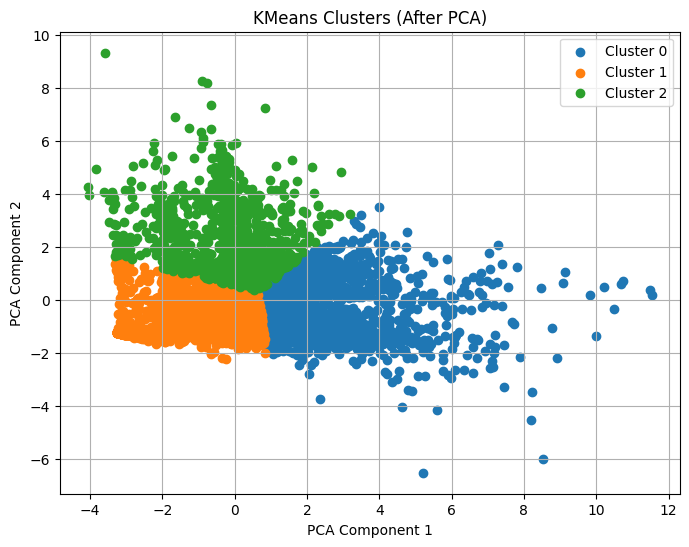

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for cluster in range(optimal_clusters):
    cluster_data = df_trip_agg[df_trip_agg['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('KMeans Clusters (After PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()


In [33]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculate Silhouette Score
sil_score = silhouette_score(pca_data, clusters)
print(f"Silhouette Score: {sil_score}")

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(pca_data, clusters)
print(f"Calinski-Harabasz Index: {ch_score}")

# Calculate Davies-Bouldin Index
db_score = davies_bouldin_score(pca_data, clusters)
print(f"Davies-Bouldin Index: {db_score}")

Silhouette Score: 0.45678402012023217
Calinski-Harabasz Index: 4363.554636668727
Davies-Bouldin Index: 0.8198918292777394


In [34]:
# Save the DataFrame to a CSV file
output_file = "trip_clusters.csv"
df_trip_agg.to_csv(output_file, index=False)
print(f"Data has been saved to {output_file}")

Data has been saved to trip_clusters.csv


In [35]:
# Step 1: Group by 'deviceID' and get the most frequent cluster label (mode)
vehicle_cluster = df_trip_agg.groupby('deviceID_')['cluster'].agg(lambda x: x.mode()[0]).reset_index()

In [36]:
# Define a combined mapping with both driving style and price category
combined_mapping = {
    0: 'Harsh Driving - Extra Charge (120%)',        # Cluster 0: Safe driving behavior with Premium pricing
    1: 'Safe Driving - Standard (100%)',     # Cluster 1: Harsh driving behavior with Standard pricing
    2: 'Efficient Driving - Premium (80%)' # Cluster 2: Efficient driving behavior with Extra charge pricing
}

# Apply combined labels to the DataFrame
vehicle_cluster['driving_style_and_price'] = vehicle_cluster['cluster'].map(combined_mapping)

# Sort the DataFrame by driving style for better clarity
sorted_vehicle_cluster = vehicle_cluster.sort_values(by='driving_style_and_price')

# Print the sorted table with deviceID and combined driving style + price category
print(sorted_vehicle_cluster[['deviceID_', 'driving_style_and_price']])

    deviceID_              driving_style_and_price
0           1    Efficient Driving - Premium (80%)
2           4    Efficient Driving - Premium (80%)
21         46    Efficient Driving - Premium (80%)
18         43    Efficient Driving - Premium (80%)
16         37    Efficient Driving - Premium (80%)
23         51    Efficient Driving - Premium (80%)
14         35    Efficient Driving - Premium (80%)
6          12  Harsh Driving - Extra Charge (120%)
7          13  Harsh Driving - Extra Charge (120%)
17         38  Harsh Driving - Extra Charge (120%)
22         47       Safe Driving - Standard (100%)
20         45       Safe Driving - Standard (100%)
19         44       Safe Driving - Standard (100%)
15         36       Safe Driving - Standard (100%)
12         28       Safe Driving - Standard (100%)
11         23       Safe Driving - Standard (100%)
10         20       Safe Driving - Standard (100%)
9          19       Safe Driving - Standard (100%)
8          15       Safe Drivin

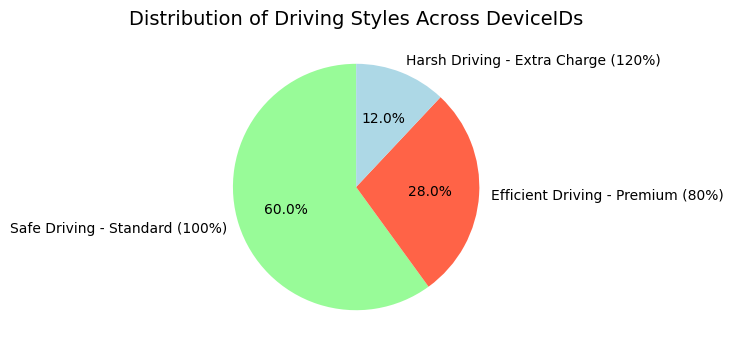

In [37]:
# Count the occurrences of each driving style
driving_style_counts = vehicle_cluster['driving_style_and_price'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(driving_style_counts, labels=driving_style_counts.index, 
        autopct='%1.1f%%', startangle=90, colors=['#98FB98', '#FF6347', '#ADD8E6'])

# Title
plt.title('Distribution of Driving Styles Across DeviceIDs', fontsize=14)

# Show the plot
plt.show()
